# Preparation for 'experimental' Linear Regression

In [1]:
import pandas as pd
import numpy as np
import pickle
import dill
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


**In this notebook I will make some Data Cleaning and Exploratory Data Analysis steps to prepare for the experimental linear regression step that will indicate how well the linear regression MIGHT perform with more data. Mainly I will readd variables I had to remove because of the faulty survey technique used to gather this data. Those new Data make it necessary to repeat some Data Cleaning and Exploratory Data Analysis steps. Both will not be very extensive though, as I've already performed cleaning and exploring before.**

In [2]:
with open('indians.pickle','rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [3]:
with open('indians_itself.pickle','rb') as f:
    indians = pickle.load(f)

**First I need to create DataFrames of training and test features with the old variables plus the new variables about the deceased themselves.**

In [4]:
new_X_train = indians.iloc[X_train.index][list(X_train.columns) + ['alcohol','smoke','chew','occupation_status', 'marital_status','disability_status','highest_qualification', 'deceased_sex']]

In [5]:
new_X_test = indians.iloc[X_test.index][list(X_train.columns) + ['alcohol','smoke','chew','occupation_status', 'marital_status','disability_status','highest_qualification', 'deceased_sex']]

**As in the original cleaning notebook I will replace the integers representing categories with strings describing each category.**

In [123]:
info = pd.read_excel('Mortality_data_dictionary.xlsx', sheet_name='Mortality',header=1)

In [11]:
info = info.set_index('Field Name')

In [12]:
info = info['Codes Used']

In [13]:
convert_dict = {}
for i in new_X_train.columns:
    if i in info.index:
        convert_dict[i] = info[i]
    else:
        convert_dict[i] = 'Nothing'

In [14]:
for key in convert_dict:
    if convert_dict[key] != 'Nothing' and isinstance(convert_dict[key],str):
        convert_dict[key] = convert_dict[key].split(',')
        convert_dict[key] = [string.strip().replace('=','-').split('-') for string in convert_dict[key]]
        
delete = []
for key in convert_dict:
    if convert_dict[key] == 'Nothing' or convert_dict[key] == [['None']]:
        delete.append(key)

for val in delete:
    del convert_dict[val]

In [15]:
del convert_dict['district']
convert_dict['toilet_used'][8] = ['open defecation','0']
del convert_dict['toilet_used'][9]
del convert_dict['toilet_used'][9]
del convert_dict['toilet_used'][9]
convert_dict['occupation_status'][9] += convert_dict['occupation_status'][10]
del convert_dict['occupation_status'][10]
convert_dict['occupation_status'][12] += convert_dict['occupation_status'][13] + convert_dict['occupation_status'][14]
del convert_dict['occupation_status'][13]
del convert_dict['occupation_status'][14]
convert_dict['disability_status'][6] = ['No Disability','0']
convert_dict['disability_status'].append(['Others','7'])

In [16]:
for key in convert_dict:
    in_dict = {}
    if isinstance(convert_dict[key],list):
        for sublist in convert_dict[key]:
            in_dict[int(sublist[-1])] = sublist[0]
            if len(sublist) > 2:
                for i in range(1,len(sublist)-1):
                    in_dict[int(sublist[-1])] += '_'+ sublist[i]
        convert_dict[key] = in_dict

In [17]:
for colname in new_X_train.columns:
    new_X_train[colname] = pd.to_numeric(new_X_train[colname])

In [18]:
for key in convert_dict:
    new_X_train[key] = new_X_train[key].replace(convert_dict[key])

In [19]:
for colname in new_X_test.columns:
    new_X_test[colname] = pd.to_numeric(new_X_test[colname])

In [20]:
for key in convert_dict:
    new_X_test[key] = new_X_test[key].replace(convert_dict[key])

**As visible below, there are some unwanted integers left. They weren't transformed to strings by the process above, because they do not represent any category (their meaning can't be found in the documentation of the data). I will delete rows with such meaningless integers.**

In [124]:
new_X_train.alcohol.value_counts()

Never drank           355475
Occasional drinker     82250
Usual drinker          29356
Ex – drinker            8876
Not known               1957
Name: alcohol, dtype: int64

In [45]:
new_X_train = new_X_train[(new_X_train.alcohol != 6.0) & (new_X_train.alcohol != -1.0)]

In [46]:
new_X_train.smoke.value_counts()

Never smoked         353203
Usual smoker          82483
Occasional smoker     34152
Ex – Smoker            7436
Not known              1773
Name: smoke, dtype: int64

In [47]:
new_X_train.chew.value_counts()

Never chewed                         236642
Tobacco only                         125929
Gutka/Pan masala with tobacco         46175
Pan with tobacco                      39105
Pan without tobacco                   19825
Gutka/Pan masala without tobacco       5628
Ex – Chewer                            4327
Not known                              1416
Name: chew, dtype: int64

In [50]:
new_X_train.marital_status.value_counts()

Married and Gauna performed        346762
Widow/Widower                      109494
Remarried                           11046
Never married                        8968
Separated                            1559
Divorced                              756
Married but Gauna not performed       430
Not stated                             31
-1.0                                    1
Name: marital_status, dtype: int64

In [51]:
new_X_train = new_X_train[new_X_train.marital_status != -1.0]

In [75]:
new_X_train.highest_qualification.value_counts()

Illiterate                                                                                                   180882
Literate With formal education_Middle                                                                         68987
Literate With formal education_Primary                                                                        61474
Literate With formal education_Below primary                                                                  43416
Literate With formal education_Secondary/Matric (Class_X)                                                     41933
Literate Without formal education                                                                             31878
Literate With formal education_Hr. Secondary/Sr. Secondary/Pre_university(Class XII)                          24244
Literate With formal education _ Graduate/ B.Tech/ B.B.A/ MBBS/ Equivalent                                    17902
Literate With formal education_Post Grad/ M.Tech/ M.B.A/ MD/ Equivalent 

In [76]:
new_X_train = new_X_train[new_X_train.highest_qualification != -1.0]

In [52]:
new_X_test.alcohol.value_counts()

Never drank           175492
Occasional drinker     40502
Usual drinker          14583
Ex – drinker            4389
Not known                992
-1.0                     169
6.0                        5
Name: alcohol, dtype: int64

In [55]:
new_X_test = new_X_test[(new_X_test.alcohol != 6.0) & (new_X_test.alcohol != -1.0)]

In [57]:
new_X_test.smoke.value_counts()

Never smoked         173752
Usual smoker          40793
Occasional smoker     16869
Ex – Smoker            3637
Not known               907
Name: smoke, dtype: int64

In [58]:
new_X_test.chew.value_counts()

Never chewed                         116636
Tobacco only                          61962
Gutka/Pan masala with tobacco         22737
Pan with tobacco                      19220
Pan without tobacco                    9690
Gutka/Pan masala without tobacco       2846
Ex – Chewer                            2145
Not known                               722
Name: chew, dtype: int64

In [78]:
new_X_test.marital_status.value_counts()

Married and Gauna performed        170193
Widow/Widower                       54406
Remarried                            5482
Never married                        4419
Separated                             835
Divorced                              391
Married but Gauna not performed       216
Not stated                             16
Name: marital_status, dtype: int64

In [80]:
new_X_test = new_X_test[new_X_test.highest_qualification != -1.0]

**As with the original variables, I will perform a permutation test with the new variables in order to find whether or not the two most extreme categories of each variable significantly differ at an alpha level of 0.05 in terms of the mean of the target variable.**

In [21]:
with open('permtest.pickle', 'rb') as f:
    permutation_test = dill.load(f)

In [82]:
new_indians = pd.concat([new_X_train, y_train], axis=1)

In [83]:
dicti = {}
for column in ['alcohol','smoke','chew','occupation_status', 'marital_status','disability_status','highest_qualification', 'deceased_sex']:
    if new_indians[column].dtypes == object:
        print(column)
        maxcat, mincat, diff, p, significant = permutation_test(new_indians, column, 0.05)
        dicti[column] = [maxcat, mincat, diff, p, significant]

alcohol
smoke
chew
occupation_status
marital_status
disability_status
highest_qualification
deceased_sex


In [69]:
significant = pd.DataFrame(dicti, index=['Group with highest life expectancy','Group with lowest life expectancy',\
                             'Difference between both groups','p-value','Stat. sign. at alpha 0.05?']).transpose()

In [70]:
significant

,Group with highest life expectancy,Group with lowest life expectancy,Difference between both groups,p-value,Stat. sign. at alpha 0.05?
alcohol,Ex – drinker,Not known,7.43145,0,Yes
smoke,Ex – Smoker,Not known,12.0089,0,Yes
chew,Ex – Chewer,Gutka/Pan masala with tobacco,11.232,0,Yes
occupation_status,Too old to work,Attended educational Institution,35.7692,0,Yes
marital_status,Widow/Widower,Never married,24.0371,0,Yes
disability_status,Hearing,No Disability,13.9541,0,Yes
highest_qualification,-1.0,Literate With formal education_Middle,7.19202,0,Yes
deceased_sex,Female,Male,1.00333,0,Yes


**It turned out in all variables there are statistical significant differences in mean 'lifetime'. In each the p-value is 0. Next I'll order the differences between the highest and lowest mean lifetime of the categories. I'll need this order in the fitting process.**

In [128]:
difference_order = significant["Difference between both groups"].sort_values(ascending=False)

TypeError: string indices must be integers

In [72]:
difference_order

occupation_status        35.7692
marital_status           24.0371
disability_status        13.9541
smoke                    12.0089
chew                      11.232
alcohol                  7.43145
highest_qualification    7.19202
deceased_sex             1.00333
Name: Difference between both groups, dtype: object

**Next I'll calculate the Cramer's V between all categorical values in order to find out if they are strongly associated with each other. Then I'll plot which variable pairs have a cramer's v score of at least 0.3 (meaning strong association).**

In [84]:
with open('cramers_v.pickle','rb') as f:
    cramers_v = dill.load(f)

In [85]:
categorical = new_X_train.drop('no_of_dwelling_rooms', axis=1)

In [88]:
cramers_v_matrix = pd.DataFrame()
for column1 in categorical.columns:
    c_list = []
    for column2 in categorical.columns:
        c_list.append(cramers_v(categorical[column1],categorical[column2]))
    cramers_v_matrix[column1] = c_list

In [89]:
cramers_v_matrix.index = categorical.columns

In [90]:
cramers_v_matrix

,state,district,rural,usual_residance,religion,social_group_code,house_structure,owner_status,drinking_water_source,is_water_filter,...,cart,land_possessed,alcohol,smoke,chew,occupation_status,marital_status,disability_status,highest_qualification,deceased_sex
state,1.000000,0.338913,0.142193,0.004393,0.172275,0.253464,0.218547,0.115852,0.242172,0.439034,...,0.122909,0.137475,0.125283,0.110568,0.267178,0.126768,0.057467,0.017397,0.083759,0.039448
district,0.338913,1.000000,0.178130,0.010111,0.129125,0.168822,0.155160,0.088409,0.144431,0.241195,...,0.090568,0.135706,0.094744,0.077731,0.143666,0.063755,0.031585,0.018208,0.056899,0.026201
rural,0.142193,0.178130,0.999992,0.000000,0.101057,0.095478,0.242602,0.242894,0.401751,0.160233,...,0.071609,0.354430,0.068664,0.068570,0.109034,0.305258,0.053159,0.007765,0.222516,0.018352
usual_residance,0.004393,0.010111,0.000000,0.833332,0.000000,0.000000,0.001237,0.000000,0.000774,0.000000,...,0.000000,0.000000,0.038966,0.041015,0.045883,0.011185,0.000000,0.000000,0.001472,0.000000
religion,0.172275,0.129125,0.101057,0.000000,1.000000,0.256346,0.082656,0.024884,0.066265,0.090923,...,0.029549,0.073917,0.105086,0.037170,0.061259,0.058020,0.019915,0.001910,0.043178,0.006134
social_group_code,0.253464,0.168822,0.095478,0.000000,0.256346,1.000000,0.211474,0.027919,0.133128,0.088912,...,0.033303,0.086510,0.176984,0.048584,0.111839,0.149548,0.018491,0.008691,0.118826,0.003193
house_structure,0.218547,0.155160,0.242602,0.001237,0.082656,0.211474,1.000000,0.065543,0.163747,0.020904,...,0.016169,0.047169,0.085269,0.035221,0.118520,0.153793,0.024777,0.010680,0.160068,0.010299
owner_status,0.115852,0.088409,0.242894,0.000000,0.024884,0.027919,0.065543,1.000000,0.123183,0.074696,...,0.026270,0.112674,0.050882,0.019641,0.056163,0.145535,0.023338,0.007224,0.064522,0.006795
drinking_water_source,0.242172,0.144431,0.401751,0.000774,0.066265,0.133128,0.163747,0.123183,1.000000,0.327545,...,0.026554,0.088535,0.050810,0.040506,0.084459,0.087613,0.025467,0.007538,0.076321,0.025207
is_water_filter,0.439034,0.241195,0.160233,0.000000,0.090923,0.088912,0.020904,0.074696,0.327545,0.999993,...,0.050419,0.111017,0.027735,0.064602,0.093138,0.136548,0.016543,0.005561,0.139573,0.011729


Text(0.5, 1.0, 'Cramers v')

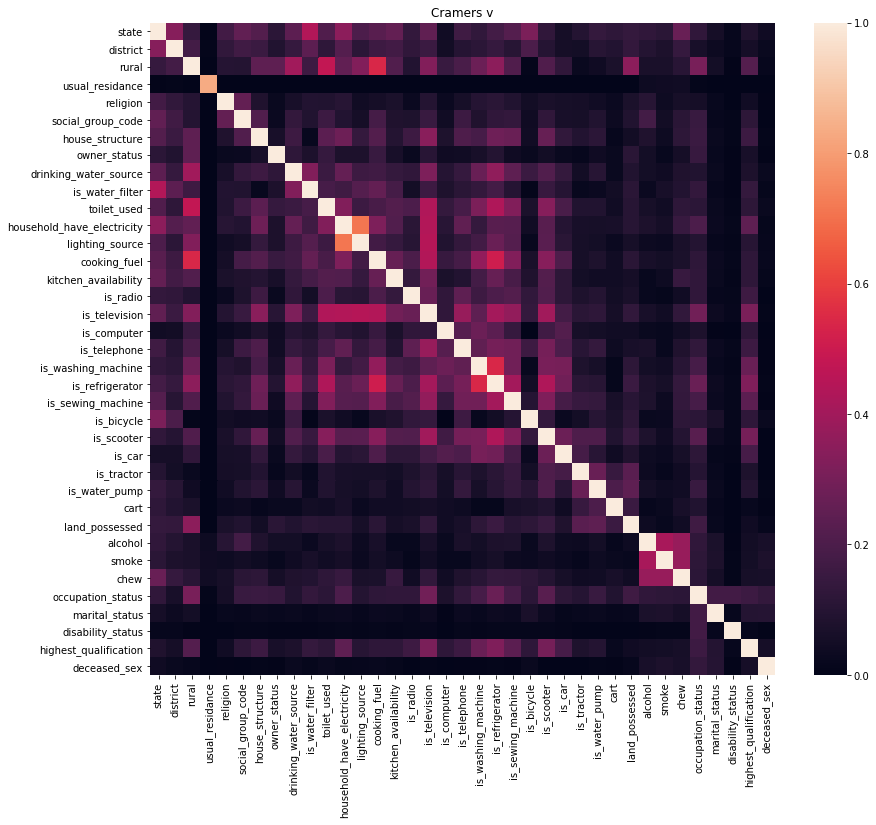

In [93]:
plt.figure(figsize=(14,12))
sns.heatmap(cramers_v_matrix)
plt.title('Cramers v')

In [100]:
with open('above_cv_threshold.pickle', 'rb') as f:
    above_cv_threshold = dill.load(f)

In [101]:
strong_asso = above_cv_threshold(0.3)

In [102]:
strong_asso.loc['is_car']['state']

0.058481337100023845

In [103]:
association_pairs = []
association_pairs_dict = {}
for colname in strong_asso.columns:
    print(colname + ':\n')
    association_pairs_dict[colname] = []
    for rowname in strong_asso.index:
        if colname != rowname:
            if strong_asso.loc[rowname][colname] >= 0.3:
                print(colname + ' is associated with ' + rowname + '. Association: ' + str(strong_asso.loc[rowname][colname]))
                association_pairs.append((colname,rowname))
                association_pairs_dict[colname].append(rowname)
    print('\n\n')

state:

state is associated with district. Association: 0.3389130608404145
state is associated with is_water_filter. Association: 0.4390344912477915
state is associated with household_have_electricity. Association: 0.3522435567623113
state is associated with is_bicycle. Association: 0.3125053935218619



district:

district is associated with state. Association: 0.3389130608404145



rural:

rural is associated with drinking_water_source. Association: 0.401750747080361
rural is associated with toilet_used. Association: 0.4786180300578487
rural is associated with lighting_source. Association: 0.32548155323757566
rural is associated with cooking_fuel. Association: 0.5412295215487323
rural is associated with is_television. Association: 0.3305075034714615
rural is associated with is_refrigerator. Association: 0.3550040136339663
rural is associated with land_possessed. Association: 0.35442973060738303
rural is associated with occupation_status. Association: 0.3052581978721216



house_struc

In [104]:
association_pairs_dict

{'state': ['district',
  'is_water_filter',
  'household_have_electricity',
  'is_bicycle'],
 'district': ['state'],
 'rural': ['drinking_water_source',
  'toilet_used',
  'lighting_source',
  'cooking_fuel',
  'is_television',
  'is_refrigerator',
  'land_possessed',
  'occupation_status'],
 'house_structure': ['is_television'],
 'drinking_water_source': ['rural',
  'is_water_filter',
  'is_television',
  'is_refrigerator'],
 'is_water_filter': ['state', 'drinking_water_source'],
 'toilet_used': ['rural',
  'household_have_electricity',
  'is_television',
  'is_washing_machine',
  'is_refrigerator',
  'is_sewing_machine',
  'is_scooter'],
 'household_have_electricity': ['state',
  'toilet_used',
  'lighting_source',
  'cooking_fuel',
  'is_television'],
 'lighting_source': ['rural', 'household_have_electricity', 'is_television'],
 'cooking_fuel': ['rural',
  'household_have_electricity',
  'is_television',
  'is_washing_machine',
  'is_refrigerator',
  'is_sewing_machine',
  'is_scoot

In [106]:
graph = nx.Graph()

In [107]:
graph.add_nodes_from(strong_asso.columns)

In [108]:
for association_pair in association_pairs:
    graph.add_edge(association_pair[0],association_pair[1])

/home/florian/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


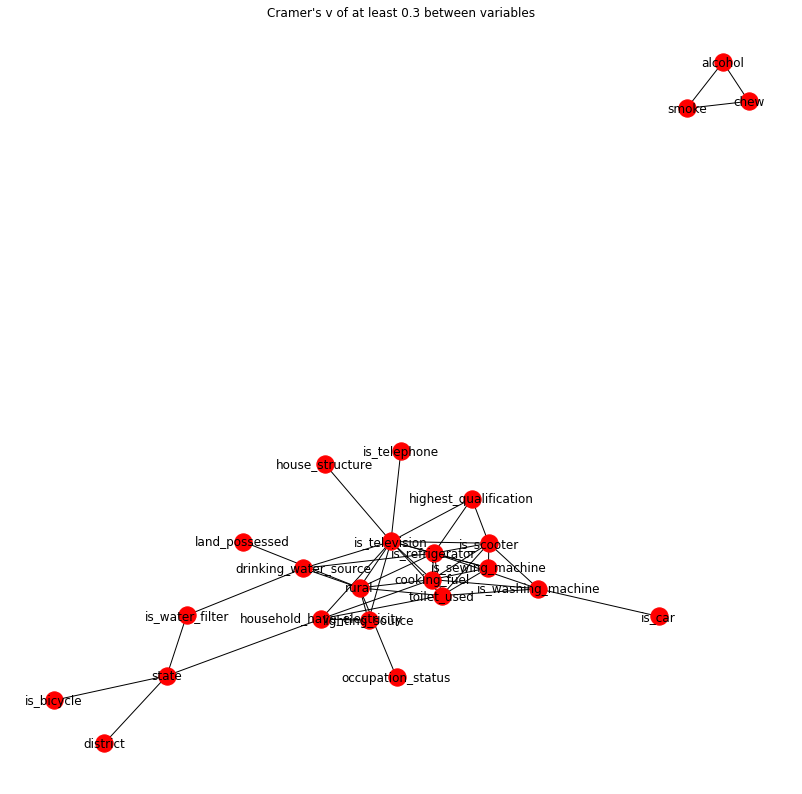

In [109]:
plt.figure(figsize=(14,14))
nx.draw_networkx(graph, with_label=True)
sns.despine(bottom=True, left=True)
plt.xticks([])
plt.yticks([])
plt.title("Cramer's v of at least 0.3 between variables")
plt.savefig('cramers_v.png')

In [120]:
new_y_train = y_train.loc[new_X_train.index]

In [121]:
new_y_test = y_test.loc[new_X_test.index]

In [122]:
with open('new_indians.pickle','wb') as f:
    pickle.dump([new_X_train, new_X_test, new_y_train, new_y_test] ,f)

In [111]:
with open('asspairs_diffo.pickle','wb') as f:
    pickle.dump([association_pairs_dict, difference_order], f)